# Initialization

In [1]:
!pip install boto3 progressbar2 sfdmap GPUtil astropy

In [2]:
# imports
import pandas as pd
import numpy as np
import os
import sys
import pickle
from matplotlib import pyplot as plt
import matplotlib
import boto3

# random seed
seed = 42
np.random.seed(seed)

# local files paths
local_home_dir_path = os.path.expanduser("~")
local_work_dir_path = os.path.join(local_home_dir_path, 'git')
local_code_dir_path = os.path.join(local_work_dir_path , 'code')

# S3 file paths
endpoint_url = 'https://s3-west.nrp-nautilus.io'
bucket_name = 'tau-astro'
prefix = 'almogh'
s3_work_dir_path = os.path.join(prefix, 'workdir3')
s3_saves_dir_path = os.path.join(s3_work_dir_path , 'model_saves')
s3_data_dir_path = os.path.join(s3_work_dir_path , 'data')
s3_v2_data_ver_dir_path = os.path.join(s3_data_dir_path,'100K_V2')
s3_v4_data_ver_dir_path = os.path.join(s3_data_dir_path,'100K_V4')

s3_client = boto3.client("s3", endpoint_url=endpoint_url)

# adding code folder to path
sys.path.insert(1, local_code_dir_path)
from s3 import to_s3_npy, to_s3_pkl, from_s3_npy, from_s3_pkl, to_s3_fig

# Train RF

In [3]:
save_RF = True
save_RF_name = '100K_V4_full_data_set'
save_RF_dis_mat = True

load_RF = False
load_RF_name = 'simple___2021_11_27___22_09_00___standard_RF_max_depth_10'

In [4]:
assert not (save_RF and load_RF), '"save" and "load" cant both be "True"'

## Loading data

In [5]:
# load data
print('Loading data and creating dataset')
gs = from_s3_pkl(s3_client, bucket_name, os.path.join(s3_v4_data_ver_dir_path,'gs_100K_V4.pkl'))
X = from_s3_npy(s3_client, bucket_name, os.path.join(s3_v2_data_ver_dir_path, 'spec.npy'))
full_wl_grid = from_s3_npy(s3_client, bucket_name, os.path.join(s3_data_dir_path, 'wl_grid.npy'))
wl_grid = from_s3_npy(s3_client, bucket_name, os.path.join(s3_v4_data_ver_dir_path, 'wl_100K_V4.npy'))
start_i = (np.abs(full_wl_grid - wl_grid[0])).argmin()
end_i = 1+(np.abs(full_wl_grid - wl_grid[-1])).argmin()
X = X[gs.index, start_i:end_i]

Loading data and creating dataset
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V4/gs_100K_V4.pkl
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V2/spec.npy
loading from uri: s3://tau-astro/almogh/workdir3/data/wl_grid.npy
loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V4/wl_100K_V4.npy


In [6]:
assert not np.any(np.isnan(X)), 'NaN!'

## Creating train and test sets for RF

In [7]:
# creaet synthetic samples
print('Creating synthetic data')
shifts = False
if shifts:
    from CustomRandomForest import return_synthetic_data_shift, fix_nan_shifts
    X_syn = return_synthetic_data_shift(X, 10, 3, seed)
    X_syn = fix_nan_shifts(X_syn,10)
else:
    from CustomRandomForest import return_synthetic_data
    X_syn = return_synthetic_data(X, seed)

# merge the data
print('Merging')
from uRF_SDSS import merge_work_and_synthetic_samples
Z, y = merge_work_and_synthetic_samples(X, X_syn)

# train-test split
from sklearn.model_selection import train_test_split
Z_train, Z_test, y_train, y_test, I_train, I_test = train_test_split(Z, y, np.arange(len(y)), train_size=190000, random_state=seed)

Creating synthetic data


100% (8400 of 8400) |####################| Elapsed Time: 0:00:30 Time:  0:00:30


Merging


## Fit a random forest

In [8]:
if load_RF:
    
    s3_load_dir_path = os.path.join(s3_saves_dir_path, 'RF', load_RF_name)
    print('loading from folder (S3): {0}'.format(s3_load_dir_path))
    
    #I_slice = from_s3_npy(s3_client, bucket_name, os.path.join(s3_load_dir_path, 'I_slice.npy'))
    I_train = from_s3_npy(s3_client, bucket_name, os.path.join(s3_load_dir_path, 'I_train.npy'))
    wl_grid = from_s3_npy(s3_client, bucket_name, os.path.join(s3_load_dir_path, 'wl_grid.npy'))
    
    from CustomRandomForest import CustomRandomForest
    rf = CustomRandomForest.load_s3(s3_client, bucket_name, os.path.join(s3_load_dir_path, 'crf.pkl'))
    
else:

    # RF parameters
    N_trees = 500
    min_span = len(wl_grid)
    max_span = len(wl_grid)
    min_samples_split = 10000
    max_features = 'sqrt'
    max_samples = 1.0
    max_depth = 10
    N_snr_bins = 1

    # create a random forest
    from CustomRandomForest import CustomRandomForest
    rf = CustomRandomForest(N_trees=N_trees,
                            min_span=min_span,
                            max_span=max_span,
                            min_samples_split=min_samples_split,
                            max_features=max_features,
                            max_samples=max_samples,
                            max_depth=max_depth
                           )

    # fit the forest to the data
    rf.fit(Z_train, y_train, prefer='threads', n_jobs=16)

    if save_RF:

        # create a save dir
        from datetime import datetime
        s3_save_dir_path = os.path.join(s3_saves_dir_path, 'RF', 'simple___' + datetime.now().strftime("%Y_%m_%d___%H_%M_%S") + '___' + save_RF_name)
        print('save folder (S3): ' + s3_save_dir_path)

        # save some data
        print('Saving numpy arrays')
        #to_s3_npy(I_slice, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'I_slice.npy'))
        to_s3_npy(I_train, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'I_train.npy'))
        #to_s3_npy(wl_grid, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'wl_grid.npy'))

        # save the random forest
        print('Saving the random forest')
        rf.save_s3(s3_client, bucket_name, os.path.join(s3_save_dir_path, 'crf.pkl'))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:  4.0min
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed: 10.2min
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed: 19.3min
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed: 30.8min
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed: 36.4min finished


save folder (S3): almogh/workdir3/model_saves/RF/simple___2022_05_09___21_55_53___100K_V4_full_data_set
Saving numpy arrays
saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_05_09___21_55_53___100K_V4_full_data_set/I_train.npy
Saving the random forest
saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_05_09___21_55_53___100K_V4_full_data_set/crf.pkl


## Evaluate the RF

In [9]:
if not load_RF:

    print('Predict on training set')
    y_hat_train = rf.predict(Z_train)

    print('Predict on test set')
    y_hat_test = rf.predict(Z_test)

    print('Evaluating')
    from sklearn.metrics import classification_report
    train_set_report = classification_report(y_train, y_hat_train)
    test_set_report = classification_report(y_test, y_hat_test)
    print('TRAININ-SET:')
    print(train_set_report )
    print('TEST-SET:')
    print(test_set_report)

    if save_RF:

        from s3 import log_s3
        log_s3(s3_client, bucket_name, path_in_bucket=s3_save_dir_path, log_name='RF_log.txt',
            #data = '\n'.join([original_wl_str, new_wl_str, samples_str]),
            N_RF_train_real = sum(y_train==1),
            N_RF_train_syn = len(y_train)-sum(y_train==1),
            N_RF_test_real = sum(y_test==1),
            N_RF_test_syn = len(y_test)-sum(y_test==1),
            N_trees = rf.N_trees,
            min_span = rf.min_span,
            max_span = rf.max_span,
            min_samples_split = rf.min_samples_split,
            max_features = rf.max_features,
            max_samples = rf.max_samples,
            max_depth = rf.max_depth,
            train_set_report = '\n'+train_set_report,
            test_set_report = '\n'+test_set_report
            )

Predict on training set
apply: starting 500 jobs


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.0min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished


Predict on test set
apply: starting 500 jobs


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   33.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Evaluating
TRAININ-SET:
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99     95059
         2.0       0.99      0.99      0.99     94941

    accuracy                           0.99    190000
   macro avg       0.99      0.99      0.99    190000
weighted avg       0.99      0.99      0.99    190000

TEST-SET:
              precision    recall  f1-score   support

         1.0       0.98      0.99      0.99      4941
         2.0       0.99      0.98      0.99      5059

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_05_09___21_55_53___100K_V4_full_data_set/RF_log.txt


###  Plots

apply: starting 500 jobs


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   31.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


apply: starting 500 jobs


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished


saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_05_09___21_55_53___100K_V4_full_data_set/prob_dist.png


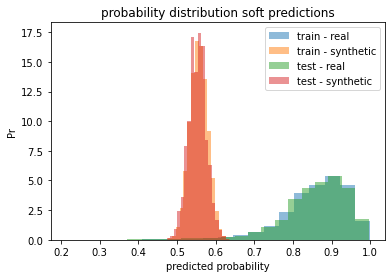

In [10]:
if not load_RF:

    p_test = rf.predict_proba(Z_test)
    p_train = rf.predict_proba(Z_train)

    fig = plt.figure()
    plt.hist(p_train[y_train==1,1], density=True, bins=20, alpha=0.5, label='train - real')
    plt.hist(p_train[y_train==2,2], density=True, bins=20, alpha=0.5, label='train - synthetic')
    plt.hist(p_test[y_test==1,1], density=True, bins=20, alpha=0.5, label='test - real')
    plt.hist(p_test[y_test==2,2], density=True, bins=20, alpha=0.5, label='test - synthetic')
    plt.legend()
    plt.title("probability distribution soft predictions")
    plt.ylabel("Pr")
    plt.xlabel("predicted probability")

    if save_RF:
        to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'prob_dist.png'))

## Calculate similarity matrix, weirdness scores and T-SNE

In [ ]:
if load_RF:
    
    print('loading...')
    X = from_s3_npy(s3_client, bucket_name, os.path.join(s3_load_dir_path, 'X.npy'))
    X_leaves = from_s3_npy(s3_client, bucket_name, os.path.join(s3_load_dir_path, 'X_leaves.npy'))
    Y_hat = from_s3_npy(s3_client, bucket_name, os.path.join(s3_load_dir_path, 'Y_hat.npy'))
    sim_mat = from_s3_npy(s3_client, bucket_name, os.path.join(s3_load_dir_path, 'sim_mat.npy'))
    
else:

    # Throwing the RF's test set, and the train synthetic spectra
    """
    because merge_work_and_synthetic_samples concatenates the N synthetic spectra after the N real spectra,
    all the train indices up to N are real.
    """
    X = X[I_train[I_train<X.shape[0]]]

    print('Applying the RF on the full dataset (real spectra only)')
    X_leaves = rf.apply(X)

    print('Predicting fully')
    Y_hat = rf.predict_full_from_leaves(X_leaves)

    print('Calculating the similarity matrix')
    from CustomRandomForest import build_similarity_matrix
    sim_mat = build_similarity_matrix(X_leaves, Y_hat)

    if save_RF:

        print('Saving the data')
        to_s3_npy(X, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'X.npy'))
        to_s3_npy(X_leaves, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'X_leaves.npy'))
        to_s3_npy(Y_hat, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'Y_hat.npy'))

        print('Saving the similarity matrix')
        to_s3_npy(sim_mat, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'sim_mat.npy'))

Applying the RF on the full dataset (real spectra only)
apply: starting 500 jobs


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.3min finished


Predicting fully


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished


Calculating the similarity matrix


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 2114 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 2528 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 2978 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 3464 tasks      | elapsed: 24.6min
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done 4544 tasks      | e

In [ ]:
print('Calculating the weirdness scores')
dis_mat = 1 - sim_mat
weird_scores = np.mean(dis_mat, axis=1)

if save_RF:

    print('Saving the weirdness scores')
    to_s3_npy(weird_scores, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'weird_scores.npy'))

    if save_RF_dis_mat:
        print('Saving the dissimilarity matrix')
        to_s3_npy(dis_mat, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'dis_mat.npy'))

In [ ]:
if load_RF:
    
    print('loading...')
    sne = from_s3_npy(s3_client, bucket_name, os.path.join(s3_load_dir_path, 'tsne.npy'))
    
else:

    print('Running T-SNE')
    from sklearn.manifold import TSNE
    sne = TSNE(n_components=2, perplexity=25, metric='precomputed', verbose=1, random_state=seed).fit_transform(dis_mat)

    if save_RF:

        print('Saving T-SNE')
        to_s3_npy(sne, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'tsne.npy'))

# Plots

In [ ]:
if not load_RF:
    
    fig = plt.figure()
    tmp = plt.hist(weird_scores, bins=60, color="g")
    plt.title("Weirdness score histogram")
    plt.ylabel("N")
    plt.xlabel("weirdness score")

    if save_RF:
        to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'weirdness_scores_histogram.png'))

In [ ]:
if not load_RF:

    distances = dis_mat[np.tril_indices(dis_mat.shape[0], -1)]

    fig = plt.figure()
    tmp = plt.hist(distances, bins=100)
    plt.title("Distances histogram")
    plt.ylabel("N")
    plt.xlabel("distance")

    if save_RF:
        to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'distances_histogram.png'))

In [ ]:
if not load_RF:
    
    sne_f1 = sne[:, 0]
    sne_f2 = sne[:, 1]

    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    im_scat = ax.scatter(sne_f1, sne_f2, s=3, c=weird_scores, cmap=plt.cm.get_cmap('jet'), picker=1)
    ax.set_xlabel('t-SNE Feature 1')
    ax.set_ylabel('t-SNE Feature 2')
    ax.set_title(r't-SNE Scatter Plot Colored by Weirdness score')
    clb = fig.colorbar(im_scat, ax=ax)
    clb.ax.set_ylabel('Weirdness', rotation=270)
    plt.show()

    if save_RF:
        to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'tsne_colored_by_weirdness.png'))

In [ ]:
I_real_train = I_train[I_train<10000]
snr = gs.snMedian.iloc[I_real_train]

In [ ]:
if not load_RF:
    
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    import matplotlib.colors as colors
    im_scat = ax.scatter(sne_f1, sne_f2, s=3, c=snr, cmap=plt.cm.get_cmap('jet'), norm=colors.LogNorm(vmin=snr.min(), vmax=80))
    ax.set_xlabel('t-SNE Feature 1')
    ax.set_ylabel('t-SNE Feature 2')
    ax.set_title(r't-SNE Scatter Plot Colored by SNR')
    clb = fig.colorbar(im_scat, ax=ax)
    clb.ax.set_ylabel('SNR', rotation=270)
    plt.show()

if save_RF:
    to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_save_dir_path, 'tsne_colored_by_snr.png'))